## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

## Get the data

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

In [3]:
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Clean the data

In [5]:
raw_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
raw_dataset = raw_dataset.dropna()

## Vectorize column

In [7]:
raw_dataset.Origin.unique()

array([1, 3, 2])

In [8]:
raw_dataset["Origin"] = raw_dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})

In [9]:
dataset = pd.get_dummies(raw_dataset)

In [10]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Europe,Origin_Japan,Origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Split the dataset into train and test

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
len(train_dataset), len(test_dataset)

(314, 78)

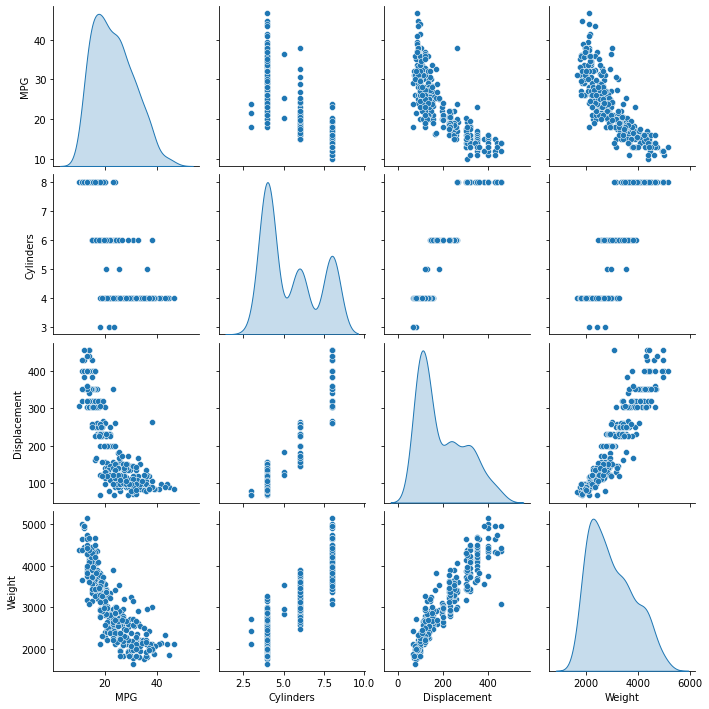

In [13]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [14]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin_Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Origin_Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
Origin_USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split labels from features

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

## Linear regression using one variable

In [16]:
horsepower = np.array(train_features["Horsepower"])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [17]:
horsepower_model = tf.keras.Sequential([
                                        horsepower_normalizer,
                                        tf.keras.layers.Dense(1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Always run once on random data and check if the output is as expected.

In [18]:
horsepower_model.predict(horsepower[:10])

array([[-0.5020349 ],
       [-0.28353545],
       [ 0.92661524],
       [-0.70372665],
       [-0.63649607],
       [-0.24992014],
       [-0.75414956],
       [-0.63649607],
       [-0.16588192],
       [-0.28353545]], dtype=float32)

Once the model is built, compile the model giving it loss and optimizer.

In [19]:
horsepower_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                         loss=tf.keras.losses.mean_absolute_error)

## Lets train the model

In [20]:
history = horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

## Plot the results

In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

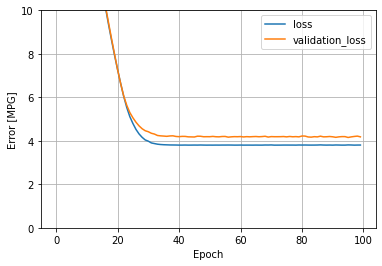

In [22]:
plot_loss(history)

Store the test results for future use

In [23]:
test_results = dict()

test_results["horsepower_model"] = horsepower_model.evaluate(
    test_features.Horsepower,
    test_labels,
    verbose=0
)

In [24]:
test_results['horsepower_model']

3.6558191776275635

## Plot the results

Since it is a single variable regression model, we can easily plot the results

In [25]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [26]:
def plot_horsepower(x, y):
  plt.scatter(train_features.Horsepower, train_labels, label="Data")
  plt.plot(x, y, color='k', label="Predictions")
  plt.xlabel("Horsepower")
  plt.ylabel("MPG")
  plt.legend()

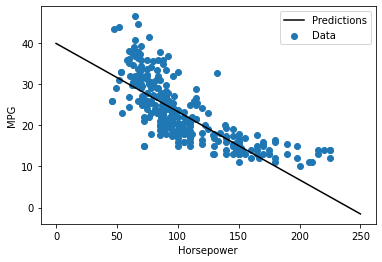

In [27]:
plot_horsepower(x, y)

## Regression using Multiple Inputs

In [28]:
normalizer = preprocessing.Normalization()

normalizer.adapt(np.array(train_features))

In [29]:
linear_model = tf.keras.Sequential([
                                    normalizer,
                                    tf.keras.layers.Dense(1)
])

In [30]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=tf.keras.losses.mean_absolute_error
)

In [31]:
linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [32]:
linear_model.predict(train_features[:10])

array([[-2.8367333 ],
       [-1.7920091 ],
       [ 1.488699  ],
       [-1.5375133 ],
       [ 0.5903034 ],
       [-0.507073  ],
       [ 0.2833705 ],
       [-0.02215642],
       [-1.286233  ],
       [-0.56500006]], dtype=float32)

In [33]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

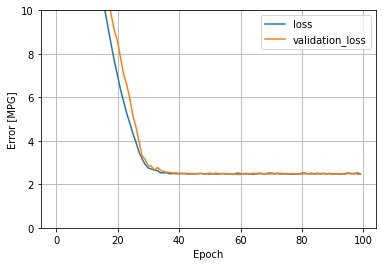

In [34]:
plot_loss(history)

In [35]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

In [36]:
test_results['linear_model']

2.4700634479522705

## DNN Regression

In [37]:
model = tf.keras.Sequential([
                             normalizer,
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.Dense(units=1)
])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.mean_absolute_error
)

In [40]:
history = model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

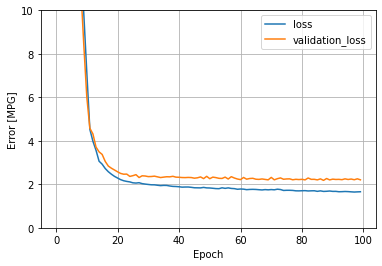

In [41]:
plot_loss(history)

In [45]:
test_results['dnn_model'] = model.evaluate(test_features, test_labels, verbose=0)

In [46]:
test_results

{'dnn_model': 1.690948486328125,
 'horsepower_model': 3.6558191776275635,
 'linear_model': 2.4700634479522705}

In [49]:
pd.DataFrame(test_results, index=["Mean Absolute Error (MPG)"]).T

,Mean Absolute Error (MPG)
horsepower_model,3.655819
linear_model,2.470063
dnn_model,1.690948


We can see that dnn model has lowest loss.